# Correlation Utilities for Replicated Samples
> Overview

This notebook contains utility functions and workflows for analyzing correlations between replicated samples in experimental data. 

In [ ]:
#| default_exp correlation_utilities

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Union, Tuple
from dataclasses import dataclass

In [ ]:
#| export
class ReplicateAnalyzer:
    """
    A class for analyzing and visualizing correlations between replicated samples.
    
    This class provides utilities for assessing reproducibility and reliability
    in experimental measurements, with a focus on correlation metrics and
    visualization tools.
    """
    
    def __init__(self, 
                 data: Optional[pd.DataFrame] = None,
                 sample_groups: Optional[List[str]] = None):
        """
        Initialize the ReplicateAnalyzer with optional data and sample groupings.
        
        Parameters
        ----------
        data : pd.DataFrame, optional
            Dataframe containing the measurement data for replicates
        sample_groups : List[str], optional
            List of sample group identifiers mapping each column in the dataframe
            to its corresponding sample group
        """
        self.data = data
        self.sample_groups = sample_groups
        self.results = {}  # Store analysis results
        
    def set_data(self, 
                data: pd.DataFrame, 
                sample_groups: List[str]):
        """
        Set or update the data and sample groupings.
        
        Parameters
        ----------
        data : pd.DataFrame
            Dataframe containing the measurement data for replicates
        sample_groups : List[str]
            List of sample group identifiers mapping each column in the dataframe
            to its corresponding sample group
        """
        self.data = data
        self.sample_groups = sample_groups
        
    def _validate_inputs(self) -> bool:
        """
        Validate that the data and sample groups are properly set and compatible.
        
        Returns
        -------
        bool
            True if inputs are valid, raises ValueError otherwise
        """
        if self.data is None:
            raise ValueError("Data has not been set. Use set_data() method first.")
            
        if self.sample_groups is None:
            raise ValueError("Sample groups have not been set. Use set_data() method first.")
            
        if len(self.sample_groups) != self.data.shape[1]:
            raise ValueError(f"Number of sample groups ({len(self.sample_groups)}) "
                           f"does not match number of data columns ({self.data.shape[1]})")
            
        return True
    
    def calculate_coefficient_of_variation(self) -> Dict[str, float]:
        """
        Calculate coefficient of variation (CV) for each sample group.
        
        The coefficient of variation is defined as the ratio of the standard deviation
        to the mean, and is a standardized measure of dispersion.
        
        Returns
        -------
        Dict[str, float]
            Dictionary mapping each sample group to its CV value
        """
        self._validate_inputs()
        
        # Get unique sample groups
        unique_groups = list(set(self.sample_groups))
        
        # Calculate CV for each group
        cv_results = {}
        
        for group in unique_groups:
            # Get column indices for this group
            group_indices = [i for i, g in enumerate(self.sample_groups) if g == group]
            
            # Extract the data for this group
            group_data = self.data.iloc[:, group_indices]
            
            # Calculate mean and std along the columns (axis=1 is for rows)
            means = group_data.mean(axis=1)
            stds = group_data.std(axis=1, ddof=1)  # ddof=1 for sample standard deviation
            
            # Calculate CV (std/mean) and average across all measurements
            # Avoid division by zero by replacing zeros with NaN
            with np.errstate(divide='ignore', invalid='ignore'):
                cv_values = stds / means
            
            # Store the mean CV for this group (ignoring NaN values)
            cv_results[group] = np.nanmean(cv_values) * 100  # Convert to percentage
        
        # Store results for later use
        self.results['cv'] = cv_results
        
        return cv_results
    
    def plot_coefficient_of_variation(self, 
                                     figsize: Tuple[int, int] = (10, 6),
                                     title: str = "Coefficient of Variation Across Sample Groups",
                                     ylabel: str = "Coefficient of Variation (%)",
                                     color: str = "skyblue",
                                     sort_values: bool = True,
                                     save_path: Optional[str] = None) -> plt.Figure:
        """
        Visualize the coefficient of variation for each sample group as a bar plot.
        
        Parameters
        ----------
        figsize : Tuple[int, int], optional
            Size of the figure (width, height) in inches
        title : str, optional
            Title of the plot
        ylabel : str, optional
            Label for the y-axis
        color : str, optional
            Color for the bars
        sort_values : bool, optional
            Whether to sort the bars by CV value (descending)
        save_path : str, optional
            Path to save the figure
            
        Returns
        -------
        plt.Figure
            The matplotlib figure object
        """
        # Calculate CV if not already done
        if 'cv' not in self.results:
            self.calculate_coefficient_of_variation()
            
        cv_data = self.results['cv']
        
        # Convert to DataFrame for easier plotting
        cv_df = pd.DataFrame({
            'Sample Group': list(cv_data.keys()),
            'CV (%)': list(cv_data.values())
        })
        
        # Sort by CV value if requested
        if sort_values:
            cv_df = cv_df.sort_values('CV (%)', ascending=False)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot the bars
        sns.barplot(x='Sample Group', y='CV (%)', data=cv_df, color=color, ax=ax)
        
        # Customize the plot
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Sample Group', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        
        # Rotate x-axis labels if there are many groups
        if len(cv_data) > 5:
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Save if a path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        return fig
    
    def get_sample_group_mapping(self) -> Dict[str, List[str]]:
        """
        Get a mapping of sample groups to their corresponding column names.
        
        Returns
        -------
        Dict[str, List[str]]
            Dictionary mapping each sample group to a list of column names
        """
        self._validate_inputs()
        
        mapping = {}
        for group, col_name in zip(self.sample_groups, self.data.columns):
            if group not in mapping:
                mapping[group] = []
            mapping[group].append(col_name)
            
        return mapping

    # Additional methods can be added here for future functionalities

Coefficient of Variation Results:
{'mysample_1': 17.080592807021713, 'mysample_2': 31.238071697274144}

Sample Group Mapping:
mysample_1: ['S1-Replica1', 'S1-Replica2', 'S1-Replica3']
mysample_2: ['S2-Replica1', 'S2-Replica2', 'S2-Replica3']


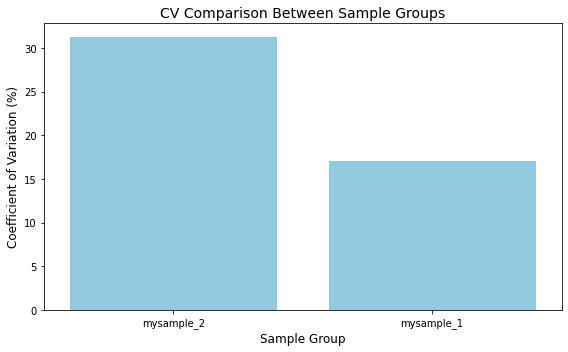

In [ ]:
import pandas as pd
import numpy as np


# Example data creation
np.random.seed(42)  # For reproducibility

# Create a sample dataframe with replicated measurements
# Let's say we have 100 genes measured across 2 sample groups with 3 replicates each
n_genes = 100

# Sample 1 replicates with moderate variability
s1_rep1 = np.random.lognormal(mean=2, sigma=0.2, size=n_genes)
s1_rep2 = np.random.lognormal(mean=2, sigma=0.2, size=n_genes)
s1_rep3 = np.random.lognormal(mean=2, sigma=0.2, size=n_genes)

# Sample 2 replicates with higher variability
s2_rep1 = np.random.lognormal(mean=1.5, sigma=0.4, size=n_genes)
s2_rep2 = np.random.lognormal(mean=1.5, sigma=0.4, size=n_genes)
s2_rep3 = np.random.lognormal(mean=1.5, sigma=0.4, size=n_genes)

# Create dataframe
data = pd.DataFrame({
    'S1-Replica1': s1_rep1,
    'S1-Replica2': s1_rep2,
    'S1-Replica3': s1_rep3,
    'S2-Replica1': s2_rep1,
    'S2-Replica2': s2_rep2,
    'S2-Replica3': s2_rep3
})

# Define sample groups
sample_groups = ['mysample_1', 'mysample_1', 'mysample_1', 
                'mysample_2', 'mysample_2', 'mysample_2']

# Initialize analyzer with data
analyzer = ReplicateAnalyzer(data, sample_groups)

# Calculate coefficient of variation
cv_results = analyzer.calculate_coefficient_of_variation()
print("Coefficient of Variation Results:")
print(cv_results)

# Visualize the results
fig = analyzer.plot_coefficient_of_variation(
    title="CV Comparison Between Sample Groups",
    figsize=(8, 5)
)

# Get mapping of sample groups to column names
mapping = analyzer.get_sample_group_mapping()
print("\nSample Group Mapping:")
for group, columns in mapping.items():
    print(f"{group}: {columns}")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()